# NOTE: We have never actually learned how to get a Neural Network to predict FUTURE prices. I can't find anything on the subject (except for one day out).


# We might have to drop that part.

# Jeff you were right! "If it were that easy, wouldn't everyone be doing it". Sorry senpai:)

# Imports

# 1. Preprocess
* Get data from an API
* Filter out the data we don't need

* Scale the data
* Set up a train test split on the data

In [65]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas as hvplot
sns.set_style('darkgrid')

In [66]:
ticker = 'GOOGL'
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
df = yf.download(ticker, 
            period = '5y', # A period of 2 years from today
            prepost = True, # Pre and Post markets included
            threads = True # Multi-thread processing for faster output.
           )
df # This data already looks like it is based of business days.
# Rearranging the columns to help with the Heatmap
df = df[['Close','Open','High','Low','Volume']]
df

[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,Volume
Date,,,,,
2016-04-14,775.390015,775.359985,779.609985,773.219971,1349600
2016-04-15,780.000000,775.500000,780.929993,774.929993,1585600
2016-04-18,787.679993,780.190002,788.549988,777.609985,1677000
2016-04-19,776.250000,790.500000,790.950012,770.270020,2197600
2016-04-20,774.919983,779.159973,779.659973,771.270020,1713100
...,...,...,...,...,...
2021-04-08,2250.429932,2264.000000,2271.790039,2243.010010,1433200
2021-04-09,2270.669922,2245.439941,2273.969971,2237.260010,1304400
2021-04-12,2244.620117,2254.120117,2256.889893,2227.820068,1251200


### Getting a visual of the data asdfasdf

In [73]:
df = df['2019']

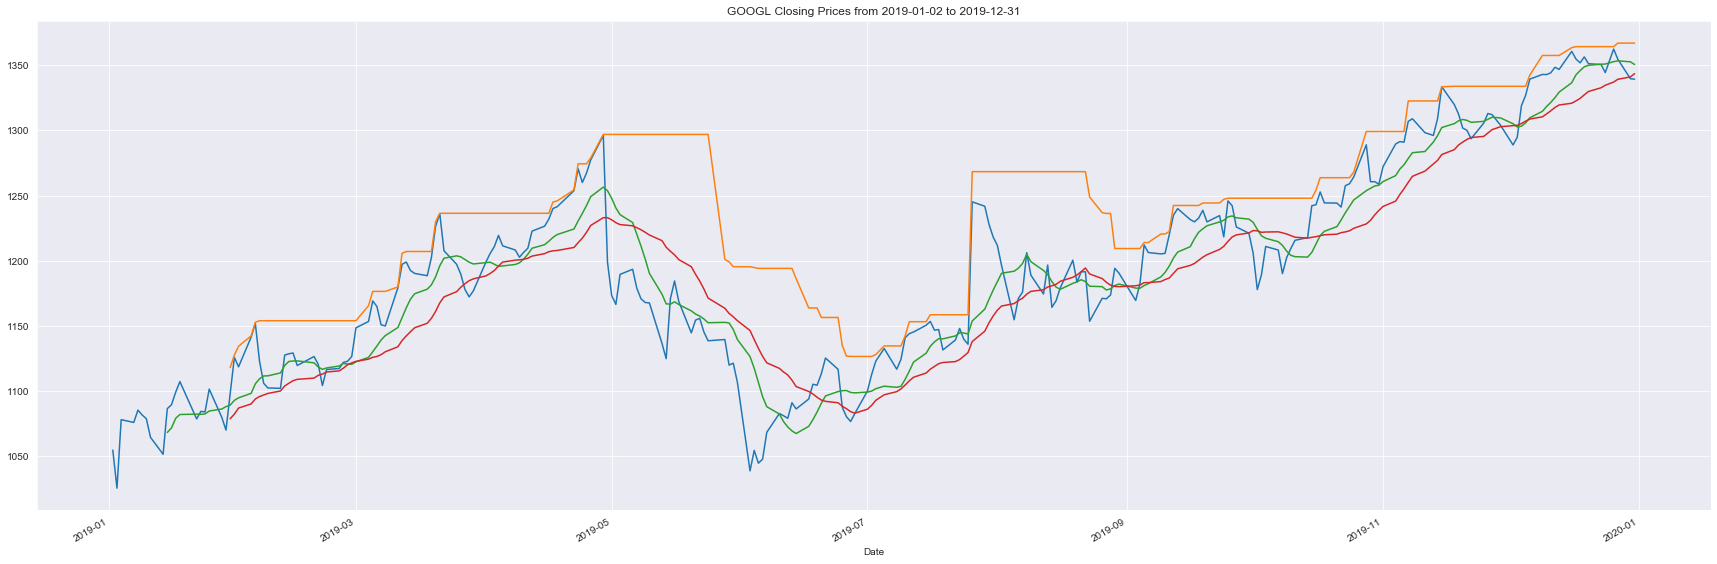

In [74]:
start_day = str(df.index[0]).split(' ')[0]
end_day = str(df.index[-1]).split(' ')[0]

twenty_day_max = df.High.rolling(window = 20).max()
# twenty_day_low = df.Low.rolling(window = 5).min()

rolling_short = df.Close.rolling(window = 10).mean()
rolling_long = df.Close.rolling(window = 20).mean()

df.Close.plot(figsize = (30,10),
             title = f'{ticker} Closing Prices from {start_day} to {end_day}', grid = True)
twenty_day_max.plot()
# twenty_day_low.plot()
rolling_short.plot()
rolling_long.plot()

# NOTE: It would be cool for this graph to display VOLUME and their averages under this.

# Potential Buy Strategy.
### Buy when 10 up crosses 20 only if you don't have any stock already.
### Sell if actual stock price is less than X% of the X-day max price.

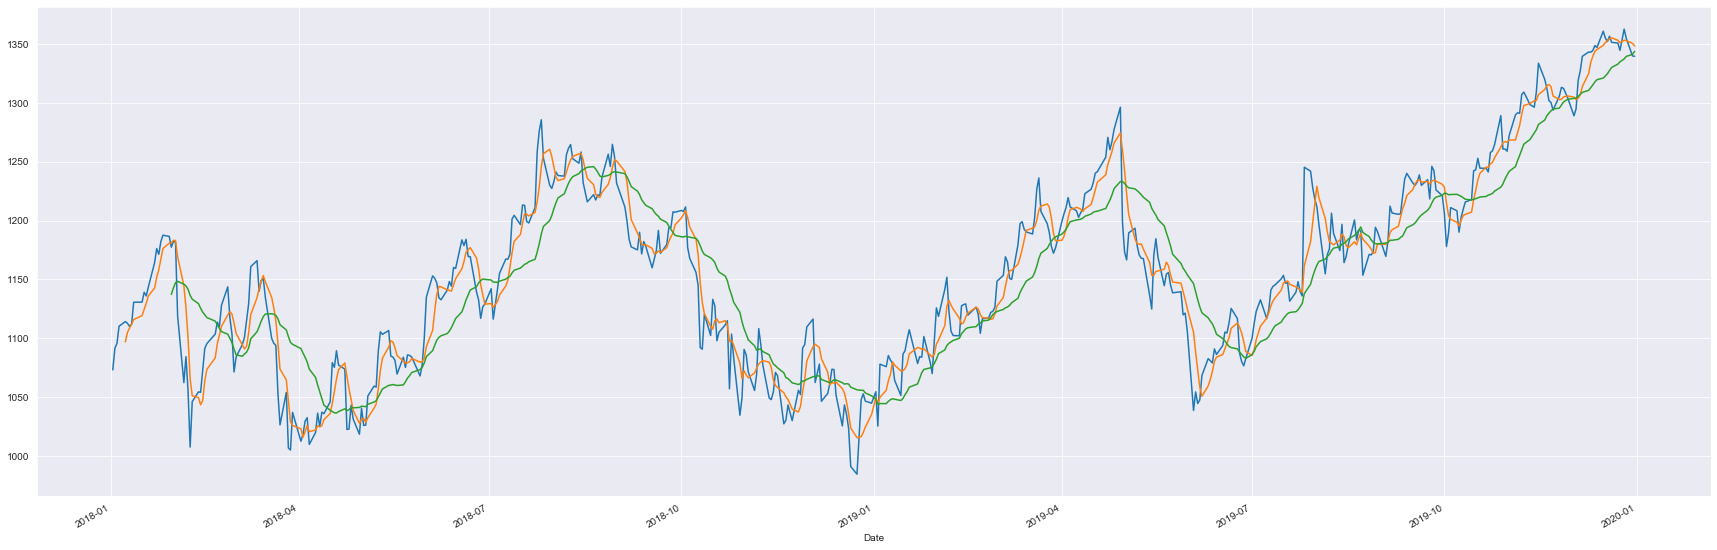

In [50]:


df.Close.plot(figsize = (30,10))


In [3]:
# Optional
#df = df.Close

### Changing the absolute values to percents

In [4]:
close_price_change = df.pct_change()

# 2. Trading Strategies

* Create a strategy that does well in BULL markets.
* Create a strategy that does well in BEAR markets.
* Create charts for both visually showing entry end exit points.
* Figure out how much would be made with a buy and hold strategy
* Create a cumulative returns graph to display the difference

# 3. Combining Trading Strategies

* Combine the strategies
* Figure out a trigger that allows the model to switch between strategies.
* Backtest the combined strategy
* Compare the cumulative returns of the buy and hold vs this strategy.

# 4. Predictive Model (Doesn't Work)
* Create a model that can predict future prices.
* Check to see if the model is over or underfit.
* Apply the combined strategy with the predicted values
* Backtest /forward test.
* Compare using a cumulative returns graph.

### Seeing which columns actually correlate.
Low correlation does not help the model.
Does high correlation actually do better?    

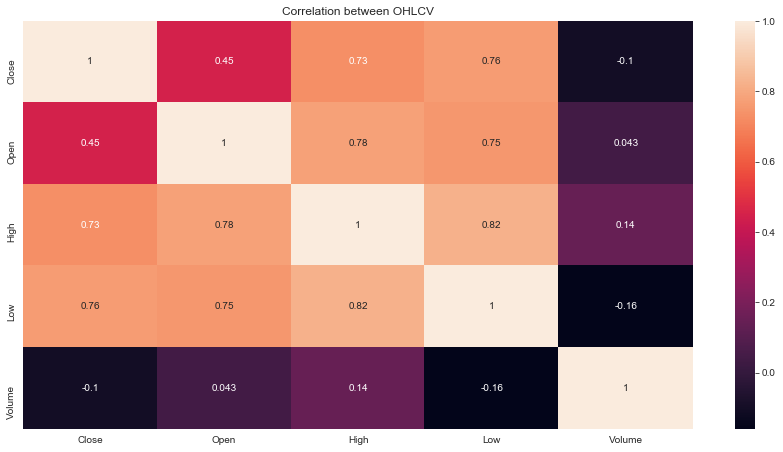

In [5]:
# sns.set_style("darkgrid")
correlation = close_price_change.corr()

fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title('Correlation between OHLCV')
heat_map = sns.heatmap(data = correlation,
#                        x = correlation.Close,
                       annot=True,
                      ax = ax)
heat_map

## This is to help us easily see which columns have low correlation to Close
### So if you were to decide to put other data in the main dataframe, this would hopefully filter that out if it wasn't useful

In [6]:
print('Correlations')
correlations = pd.DataFrame([correlation[x] for x in correlation][0])
print(correlations)

# Automatically keeping the high correlations
keepers = correlations[correlations.Close> 0.6]
keeper_columns = list(keepers.index)
print('\n\nHigh Correlations')
keeper_columns

Correlations
           Close
Close   1.000000
Open    0.449007
High    0.732242
Low     0.764539
Volume -0.102228


High Correlations


['Close', 'High', 'Low']

### I would say to only keep High and Low

In [7]:
df = df.loc[:,keeper_columns]
df = df[['Low','High','Close']]
df

,Low,High,Close
Date,,,
2019-04-15,1214.560059,1229.300049,1226.530029
2019-04-16,1225.040039,1235.979980,1231.910034
2019-04-17,1232.900024,1245.099976,1240.140015
2019-04-18,1239.410034,1245.939941,1241.469971
2019-04-22,1233.369995,1254.339966,1253.760010
...,...,...,...
2021-04-06,2201.790039,2228.000000,2209.260010
2021-04-07,2213.100098,2244.500000,2239.030029
2021-04-08,2243.010010,2271.790039,2250.429932


### Separating the data into X and y

# THE PROBLEM WITH THIS MODEL
## It doesn't predict into the actual future. It only predicts things that have already happened. 
Pretty lame. I will try to get it to predict future values.

In [37]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [38]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 2 # Close
target_column = 2
X, y = window_data(df, window_size, feature_column, target_column)

In [39]:
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [41]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [43]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [44]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 20)            1760      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 20)            3280      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [46]:
model.fit(X_train, y_train, epochs=80, shuffle=False, batch_size=1, verbose=0)

In [52]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045    


[0.004517462570220232, 0.004517462570220232]

In [53]:
predicted = model.predict(X_test)

In [54]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [55]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.tail()

,Real,Predicted
Date,,
2021-04-06,2218.959961,2010.217041
2021-04-07,2209.260010,2052.115479
2021-04-08,2239.030029,2032.391846
2021-04-09,2250.429932,2059.552979
2021-04-12,2270.669922,2069.891602


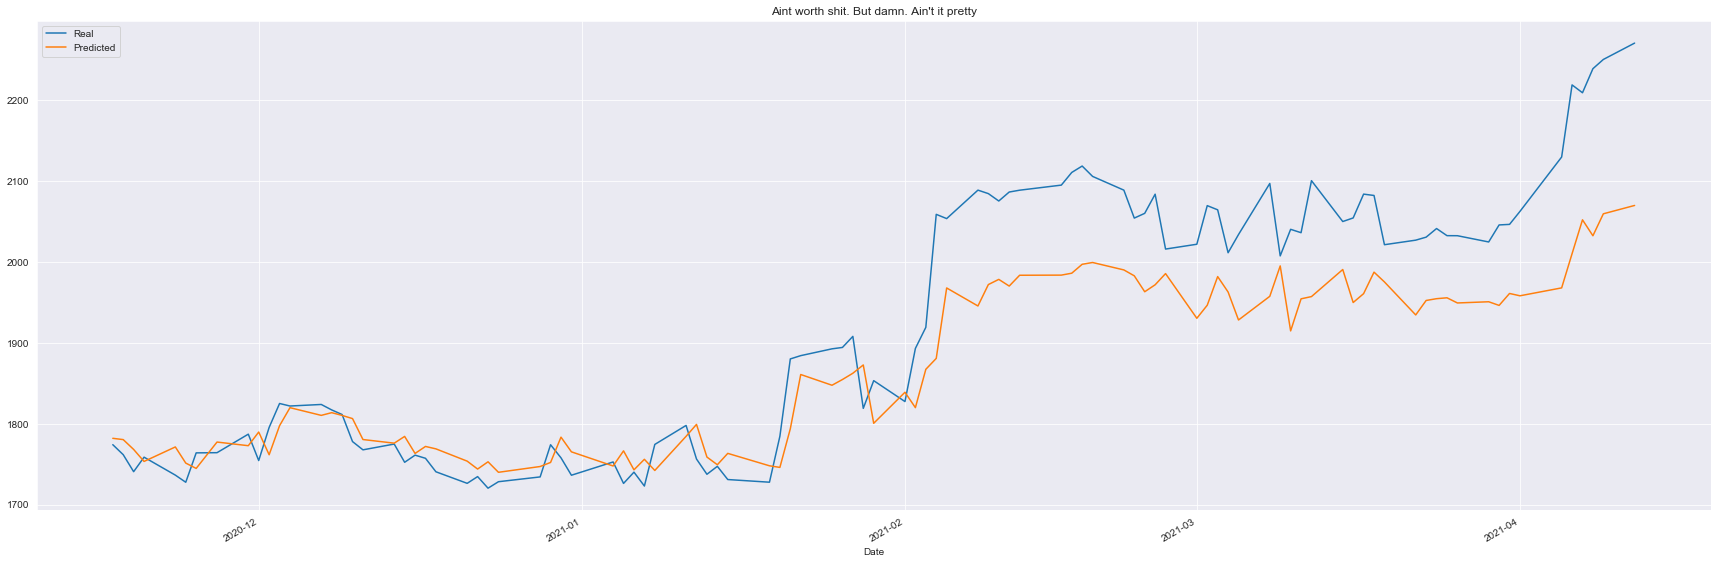

In [56]:
stocks.plot(title = "Aint worth shit. But damn. Ain't it pretty", figsize = (30, 10))

# 5. Conclusions
* How did our model do compared to a buy and hold strategy?
    * Buy how much did or didn't it suck.
    * Cumulative returns
    * Risk
    * Number of trades
    * Number of gains / (Number of gains + Number of losses)
    * ## Anything else you guys think would help in the comparison.

# Notes to eventually add to the conclusion.

We learned that using a neural network model to predict stocks is pretty naive. That doesn't seem to be their strong point. They can predict "future" prices so long as they have "future" prices to learn from. The closest I found of someone using them to actually predict future prices was a couple of people who could predict prices one day out. Now if you kept doing this, this model might be of some use. However, I couldn't get that figured out.